# Face Detection 



```
# Abraham Gil Félix | A01750884
```



Nicolas Renotte. (5 de mayo de 2022). Build a Deep Face Detection Model with Python and Tensorflow | Full Course [Archivo de video]. YouTube. https://www.youtube.com/watch?v=N_W4EYtsa10&t=5431s

## Instalación de dependencias

* Labelme permite hacer las anotaciones necesarias al conjunto de imágenes.
* Tensorflow es un framework que permite la creación de modelos de aprendizaje profundo.
* OpenCV permite la captura de imágenes en tiempo real.
* Albumentations es una herramienta de visión artificial que aumenta el rendimiento de las CNN; permite expandir el conjunto de imágenes para el entrenamiento del modelo profundo.

In [ ]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importación de librerías

In [ ]:
import os # permite que sea más fácil navegar a tráves de diferentes rutas de archivo
import time
import uuid # permite crear un identificador único a cada imagen del conjunto de datos
import cv2 # ayuda en la captura de las imágenes del conjunto de datos inicial

import tensorflow as tf 
import json # se necesita para trabajar con las etiquetas creadas a partir de labelme
import numpy as np # procesamiento de los datos
from matplotlib import pyplot as plt # visualización de las imágenes

import albumentations as alb # permite el aumento del conjunto de datos

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16, VGG19, InceptionV3, ResNet50

## Creación del conjunto de datos

* Para la creación del conjunto de datos se tomaron 3 ciclos en los cuáles el sujeto de prueba posee ropa distinta. En total, gracias a OpenCV se capturaron 90 imágenes dónde se percibe y no, el rostro del sujeto. 

In [ ]:
IMAGES_PATH = os.path.join('data','images') # path donde se guardarán las imágenes del dataset inicial (distintas carpetas)
number_images = 30 # número de imágenes a capturar por OpenCV en video

In [ ]:
cap = cv2.VideoCapture(1) # conexión con la cámara de video de la computadora. 
                          # si usted posee más de una cámara, el número 1 podría cambiar.

# ciclo for que permite la obtención de 30 imágenes 
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    # captura de la imagen
    ret, frame = cap.read() 
    # asigna el nombre a cada imagen con un identificador único
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg') 
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    # El medio segundo permite al sujeto de prueba moverse entre cada captura
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

"\ncap = cv2.VideoCapture(1)\nfor imgnum in range(number_images):\n    print('Collecting image {}'.format(imgnum))\n    ret, frame = cap.read()\n    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')\n    cv2.imwrite(imgname, frame)\n    cv2.imshow('frame', frame)\n    time.sleep(0.5)\n\n    if cv2.waitKey(1) & 0xFF == ord('q'):\n        break\ncap.release()\ncv2.destroyAllWindows()\n"

## Etiquetado del conjunto de datos

* Labelme permite etiquetar las 90 imágenes capturadas anteriormente para el conjunto de datos inicial.

In [ ]:
!labelme # esta línea de código llama a la GUI

QObject::moveToThread: Current thread (0x167a060) is not the object's thread (0x167b890).
Cannot move to target thread (0x167a060)

qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "/usr/local/lib/python3.7/dist-packages/cv2/qt/plugins" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: xcb, eglfs, linuxfb, minimal, minimalegl, offscreen, vnc, wayland-egl, wayland, wayland-xcomposite-egl, wayland-xcomposite-glx, webgl.



Nota: a pesar de que el proceso de creación de etiquetas (por medio de un cuadro delimitador) para el conjunto de imágenes inicial es manual y un poco tardado, es indispensable tener datos etiquetados para el desarrollo del proyecto.

## Carga de los datos

In [ ]:
# carga del conjunto de imágenes con ayuda de Tensorflow
# el path dado permite buscar cualquier archivo .jpg, además se mantiene el orden de las imágenes
images = tf.data.Dataset.list_files('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/data/images/*.jpg', 
                                    shuffle=False)
# permite mostrar la ruta de las imágenes, nos ayuda a confirmar que la carga de los datos fue éxitosa
images.as_numpy_iterator().next()


b'/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Te\xcc\x81cnicas y arquitecturas de Deep Learning/FaceDetection/data/images/813ae85d-5a30-11ed-81e7-48a472fee137.jpg'

In [ ]:
def load_image(x): 
  """
  Función que lee cada imagen del conjunto de datos.
  Args
    x: path del imagen
  """
  byte_img = tf.io.read_file(x)
  img = tf.io.decode_jpeg(byte_img)
  return img

In [ ]:
# La función map en Tensorflow permite aplicar una función al conjunto de datos deseado
images = images.map(load_image)

# Transformación del conjunto de imágenes
# images pasa a ser una canalización (pipeline) de Tensorflow
images.as_numpy_iterator().next()

array([[[152, 178, 177],
        [152, 178, 177],
        [151, 177, 176],
        ...,
        [195, 221, 222],
        [196, 222, 223],
        [197, 223, 224]],

       [[152, 178, 177],
        [152, 178, 177],
        [151, 177, 176],
        ...,
        [193, 221, 222],
        [194, 222, 223],
        [195, 223, 224]],

       [[150, 178, 179],
        [150, 178, 179],
        [149, 178, 176],
        ...,
        [192, 222, 220],
        [192, 222, 220],
        [193, 223, 221]],

       ...,

       [[ 14,  18,  21],
        [ 15,  19,  22],
        [ 16,  20,  21],
        ...,
        [114, 109,  90],
        [122, 117,  97],
        [123, 117,  95]],

       [[ 12,  17,  20],
        [ 13,  18,  21],
        [ 14,  19,  22],
        ...,
        [ 96,  85,  63],
        [110,  98,  74],
        [121, 109,  83]],

       [[ 10,  15,  18],
        [ 11,  16,  19],
        [ 13,  18,  21],
        ...,
        [ 54,  42,  18],
        [ 66,  50,  25],
        [ 79,  63,  37]]

### Visualización de los datos

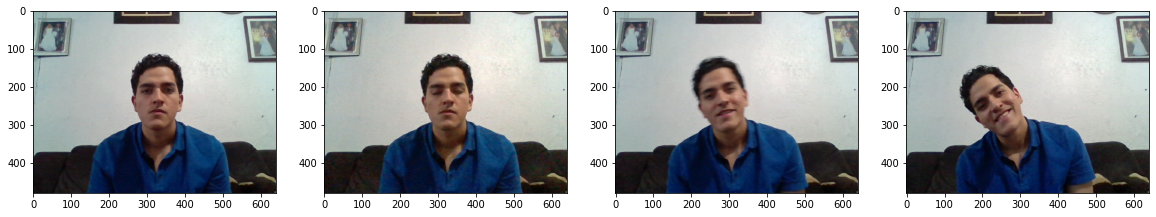

In [ ]:
# batch es una función en Tensorflow que nos ha permitido agrupar el conjunto de imágenes
# devuelve los valores dentro del lote de 4 imágenes
image_generator = images.batch(4).as_numpy_iterator()

# esta línea de código permite saltar entre cada bacth de imágenes
# la visualización muestra el siguiente lote de imágenes cada vez que se ejecute
plot_images = image_generator.next()

# visualización de cada batch de imágenes 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

## Partición de los datos

* División del conjunto de datos inicial con 90 imágenes para entrenamiento, validación y prueba.

In [ ]:
# train set
print('train set:', round(90*.7, 2)) # 63

train set: 63.0


In [ ]:
# validation set
print('validation set:', round(90*.13, 2)) # 12

validation set: 11.7


In [ ]:
# test set
print('test set:', round(90*.17, 2)) # 15

test set: 15.3


Nota: es necesario crear otras carpetas para la migración de cada imagen en su nuevo conjunto de datos.

### Match labels-images

* El siguiente ciclo permite hacer el matching de las imágenes (dentro de sus nuevos conjuntos de datos: train, val, test) con su respectiva etiqueta. Los labels se mueven desde la carpeta inicial (raw data) hacia las nuevas carpetas "train", "test" y "val" que contienen las imágenes iniciales.

In [ ]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)  

## Expansión del conjunto de datos

In [ ]:
# carga de una sola imagen del conjunto de entrenamiento
img = cv2.imread('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/data/train/images/813ae85d-5a30-11ed-81e7-48a472fee137.jpg')
# dimensiones de cada imagen
img.shape

(480, 640, 3)

### Transformación de una imagen

* El siguiente bloque de código permite visualizar la transformación que sufre una imagen con el fin de crear otras más a partir de ella. Estas líneas de código permiten al lector entender fácilemnte lo que ocurre al aumentar el conjunto de datos completo.

In [ ]:
# En el siguiente pipeline se tienen 6 diferentes técnicas para el aumento del conjunto de datos
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), # reducción del tamaño de cada imagen
                         alb.HorizontalFlip(p=0.5), # volteo horizontal
                         alb.RandomBrightnessContrast(p=0.2), # brillo aleatorio
                         alb.RandomGamma(p=0.2), # cambio de gamma 
                         alb.RGBShift(p=0.2), # RGB aleatorio de contraste
                         alb.VerticalFlip(p=0.5)], # volteo vertical
                         bbox_params=alb.BboxParams(format='albumentations', # formato del cuadro delimitador
                                                    label_fields=['class_labels']))

In [ ]:
# carga de la etiqueta
with open('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/data/train/labels/813ae85d-5a30-11ed-81e7-48a472fee137.json', 'r') as f:
    label = json.load(f)

In [ ]:
# Coordenadas
label['shapes'][0]['points']

[[241.5328467153285, 108.61313868613138],
 [408.68613138686135, 323.2116788321168]]

In [ ]:
# se almacenan "manualmente" los 4 puntos en una matriz de coordenadas 
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0] # x1
coords[1] = label['shapes'][0]['points'][0][1] # y1
coords[2] = label['shapes'][0]['points'][1][0] # x2
coords[3] = label['shapes'][0]['points'][1][1] # y2

In [ ]:
# lista con cada una de las coordenadas del cuadro delimitador
# coordenadas en el formato "pascal_voc"
coords

[241.5328467153285, 108.61313868613138, 408.68613138686135, 323.2116788321168]

In [ ]:
# transformación que divide x_min, y_min, x_max, y_max por el tamaño de cada imagen
# 480 x 640 (ancho y altura de la imagen)
coords = list(np.divide(coords, [640,480,640,480]))

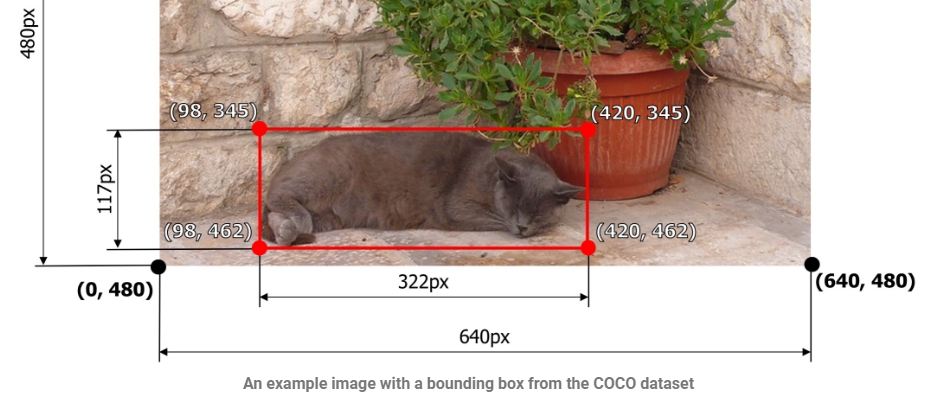

In [ ]:
# coordenadas en el formato "albumentations"
coords

[0.3773950729927008,
 0.2262773722627737,
 0.6385720802919709,
 0.6733576642335766]

In [ ]:
# se aplica el pipeline "augmentor" a la imagen ejemplo
augmented = augmentor(image=img, bboxes=[coords], class_labels=['Abraham'])

In [ ]:
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [ ]:
# coordenadas después del pipeline
augmented['bboxes']

[(0.3784752635847526,
  0.2413625304136253,
  0.74992700729927,
  0.7182481751824817)]

In [ ]:
# permite dibujar un réctangulo en cada imagen a partir de las coordenadas
# se obtienen la tuplas (x,y) verdaderas que en realidad se necesitan para el cuadro delimitador
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
              (255,0,0), 2) # formato bgr 

array([[[224, 227, 202],
        [224, 227, 202],
        [227, 227, 203],
        ...,
        [189, 183, 164],
        [189, 183, 164],
        [191, 184, 165]],

       [[223, 226, 201],
        [222, 225, 200],
        [224, 224, 200],
        ...,
        [189, 183, 164],
        [189, 183, 164],
        [190, 184, 165]],

       [[223, 223, 199],
        [223, 223, 199],
        [223, 223, 199],
        ...,
        [187, 183, 164],
        [189, 183, 164],
        [190, 184, 165]],

       ...,

       [[ 23,  21,  33],
        [ 25,  21,  33],
        [ 24,  20,  31],
        ...,
        [ 30,  26,  31],
        [ 30,  26,  31],
        [ 29,  25,  30]],

       [[ 30,  23,  38],
        [ 21,  16,  31],
        [ 30,  26,  38],
        ...,
        [ 32,  28,  34],
        [ 31,  27,  33],
        [ 32,  28,  34]],

       [[ 32,  28,  40],
        [ 26,  24,  36],
        [ 19,  17,  29],
        ...,
        [ 31,  26,  35],
        [ 30,  25,  34],
        [ 30,  26,  32]]

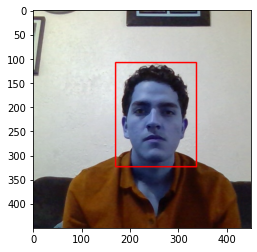

In [ ]:
# visualización imagen ejemplo transformada
plt.imshow(augmented['image'])

### Transformación para train, test and validation set

* El siguiente bloque de código recopila los pasos detallados de la sección anterior (para 1 imagen) con el propósito de transformar y aumentar todas las imágenes de los conjuntos de entrenamiento, validación y prueba. 

Nota: fue necesario la creación de nuevas carpetas para el almacenamiento de las nuevas imágenes generadas.


In [ ]:
# Ciclo for que recorre todas las carpetas donde se almacenan los conjuntos de imágenes
for partition in ['train','test','val']: 
    # cada imagen se guarda dentro de img
    for image in os.listdir(os.path.join('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/data', partition, 'images')):
        # se carga la imagen
        img = cv2.imread(os.path.join('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/data', partition, 'images', image))
        # valor predeterminado para las coordenadas (cuadro delimitador de cada imagen)
        coords = [0,0,0.00001,0.00001]
        # se carga la anotación de la imagen
        label_path = os.path.join('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/data', partition, 'labels', f'{image.split(".")[0]}.json')
        # se comprueba si existe o no una anotación, ya que algunas imágenes no tienen el cuadro delimitador
        # las imágenes que no tienen anotación son aquellas donde no se visualiza el rostro del sujeto de prueba
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            # transformación de coordenadas de "pascal_voc" a "albumentations"
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        # Ciclo que permite crear 60 imágenes diferentes a partir de la imagen cargada
        try: 
            for x in range(60):
                # Este pipeline fue declarado en la sección anterior, conserva las mismas 6 técnicas de aumento
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image
                # transformación de coordenadas 
                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 

                # guarda los cambios efectuados (etiqueta) en un json
                with open(os.path.join('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)
        
        # excepción para las imágenes con anotaciones inválidas
        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.4401231751824818, 0.2338807785888078, 0.16411952554744527, 0.6125304136253041, 'face'].
x_max is less than or equal to x_min for bbox [0.46977645985401467, 0.2095498783454988, 0.2736085766423358, 0.5684306569343066, 'face'].
x_max is less than or equal to x_min for bbox [0.19263229927007303, 0.4406934306569343, 9.581528297040177e-05, 0.9979166666666667, 'face'].


El bloque de código anterior (una genialidad) es obra de Nicholas Renotte.

### Carga de los nuevos conjuntos de datos

* En esta sección se cargan las nuevas imágenes generadas en nuestros conjuntos de datos de Tensorflow

In [ ]:
def load_image(x): 
  """
  Función que lee cada imagen del conjunto de datos.
  Args
    x: path del imagen
  """
  byte_img = tf.io.read_file(x)
  img = tf.io.decode_jpeg(byte_img)
  return img

In [ ]:
# en la variable train_images se encuentran las imágenes para el entrenamiento del modelo
train_images = tf.data.Dataset.list_files('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)

# con la función map se busca reducir el tamaño de todas las imágenes a 120 x 120,
# esto con el fin de eficientar el entrenamiento de la red neuronal profunda (menos parámetros)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))

# train_images = train_images.map(lambda x: tf.expand_dims(x, axis=2)) ---> convertion to tensor

# normalización para activación sigmoidea en la capa final del modelo 
train_images = train_images.map(lambda x: x/255)

In [ ]:
train_images

<MapDataset element_spec=TensorSpec(shape=(120, 120, None), dtype=tf.float32, name=None)>

In [ ]:
# en la variable test_images se encuentran las imágenes para el test del modelo
test_images = tf.data.Dataset.list_files('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)

# con la función map se busca reducir el tamaño de todas las imágenes a 120 x 120
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))

# test_images = test_images.map(lambda x: tf.expand_dims(x, axis=2)) ---> convertion to tensor

# normalización 0-1
test_images = test_images.map(lambda x: x/255)

In [ ]:
test_images

<MapDataset element_spec=TensorSpec(shape=(120, 120, None), dtype=tf.float32, name=None)>

In [ ]:
# en la variable val_images se encuentran las imágenes para la etapa de validación del modelo
val_images = tf.data.Dataset.list_files('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)

# con la función map se busca reducir el tamaño de todas las imágenes a 120 x 120
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))

# val_images = val_images.map(lambda x: tf.expand_dims(x, axis=2)) ---> convertion to tensor

# normalización 0-1
val_images = val_images.map(lambda x: x/255)

In [ ]:
val_images

<MapDataset element_spec=TensorSpec(shape=(120, 120, None), dtype=tf.float32, name=None)>

### Match labels-images

In [ ]:
def load_labels(label_path):
  """
  Función que lee cada etiqueta de las imágenes 
  y exrae la clase y el cuadro delimitador.
  Args
    label_path: path de la etiqueta
  """
  with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
      label = json.load(f)
        
  return [label['class']], label['bbox']

In [ ]:
# en la variable train_labels se guardan las etiquetas de las imágenes de entrenamiento
train_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
# se devuelven 2 valores: clase y coordenadas
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.419 , 0.3174, 0.7905, 0.7944], dtype=float16))

In [ ]:
# en la variable val_labels se guardan las etiquetas de las imágenes de validación
val_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
# se devuelven 2 valores: clase y coordenadas
val_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.07855, 0.3481 , 0.4062 , 0.7275 ], dtype=float16))

In [ ]:
# en la variable test_labels se guardan las etiquetas de las imágenes de validación
test_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
# se devuelven 2 valores: clase y coordenadas
test_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

## Conjuntos de datos finales

In [ ]:
# tamaño de los conjuntos de datos
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3600, 3600, 900, 900, 720, 720)

### Entrenamiento

In [ ]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(4000)
train = train.batch(8)
train = train.prefetch(4)

In [ ]:
# 8 images
train.as_numpy_iterator().next()[1]

(array([[0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0]], dtype=uint8), array([[0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.1401, 0.2178, 0.4792, 0.69  ],
        [0.4521, 0.479 , 0.807 , 0.862 ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.2266, 0.3545, 0.5024, 0.7534],
        [0.    , 0.3054, 0.2025, 0.68  ],
        [0.    , 0.    , 0.    , 0.    ]], dtype=float16))

In [ ]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [ ]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(800)
val = val.batch(8)
val = val.prefetch(4)

In [ ]:
val.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8), array([[0.     , 0.361  , 0.323  , 0.7456 ],
        [0.716  , 0.3938 , 1.     , 0.8237 ],
        [0.     , 0.2566 , 0.1829 , 0.641  ],
        [0.302  , 0.229  , 0.677  , 0.6685 ],
        [0.5146 , 0.3877 , 0.9644 , 0.772  ],
        [0.541  , 0.2927 , 0.8896 , 0.7417 ],
        [0.301  , 0.2379 , 0.676  , 0.6772 ],
        [0.10486, 0.2908 , 0.4456 , 0.683  ]], dtype=float16))

In [ ]:
val.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [ ]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1200)
test = test.batch(8)
test = test.prefetch(4)

In [ ]:
test.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0]], dtype=uint8), array([[0.1389, 0.24  , 0.4568, 0.639 ],
        [0.    , 0.3254, 0.503 , 0.932 ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.5176, 0.3044, 0.881 , 0.7275],
        [0.424 , 0.1401, 0.7856, 0.5083],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ]], dtype=float16))

In [ ]:
test.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

### Visualización

In [ ]:
data_samples = train.as_numpy_iterator()

In [ ]:
res = data_samples.next()

In [ ]:
res[1][1]

array([[0.    , 0.    , 0.    , 0.    ],
       [0.6035, 0.308 , 0.978 , 0.754 ],
       [0.    , 0.    , 0.    , 0.    ],
       [0.1046, 0.2925, 0.4436, 0.764 ],
       [0.3096, 0.2289, 0.649 , 0.701 ],
       [0.4412, 0.2966, 0.913 , 0.8823],
       [0.3015, 0.2498, 0.7183, 0.714 ],
       [0.    , 0.    , 0.    , 0.    ]], dtype=float16)

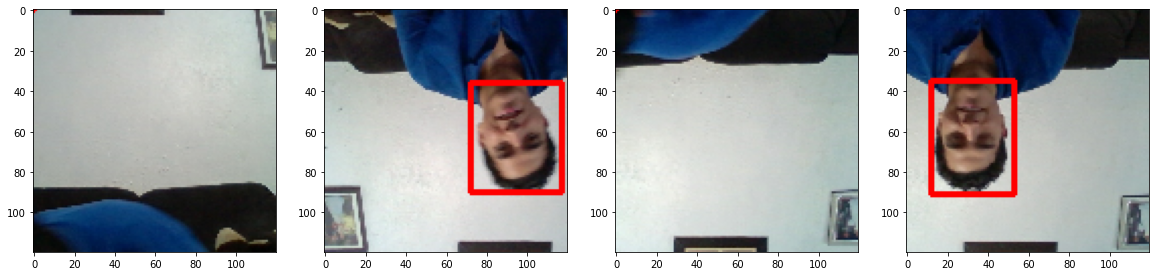

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

## Modelación NN

### Arquitectura VGG16

In [ ]:
vgg16 = VGG16(include_top=False)

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### Arquitectura InceptionV3

In [ ]:
inceptionv3 = InceptionV3(include_top=False)

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
inceptionv3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

### Modelo with VGG16

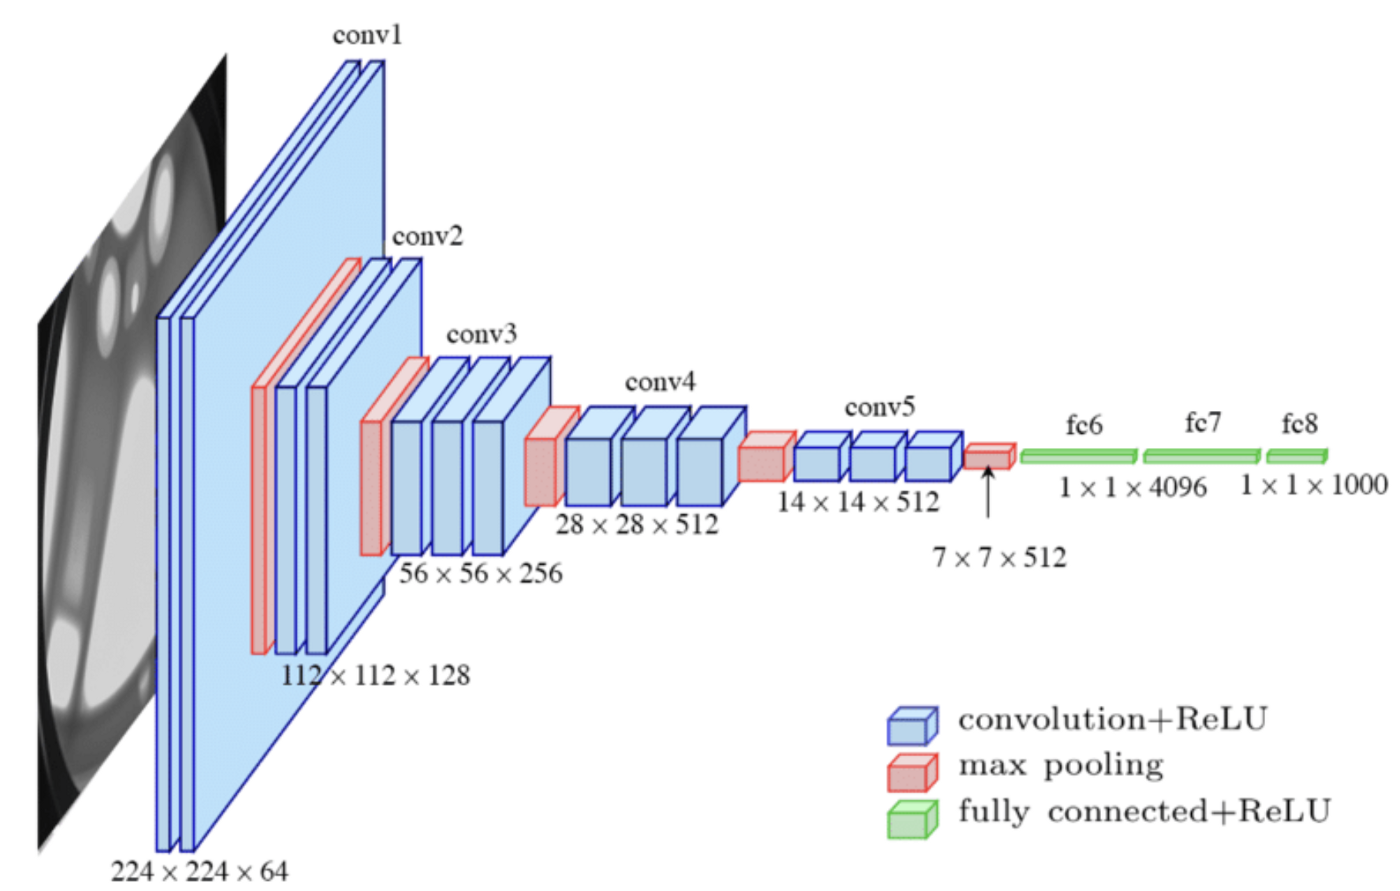

Red Neuronal Profunda ---> VGG + modelo de clasificación y modelo de regresión

In [ ]:
def build_model(): 
    input_layer = Input(shape=(120,120,3)) # image dimensions
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1) # binary classification
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1) # 4 coordinates
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [ ]:
facetracker_vgg16 = build_model()
facetracker_vgg16.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_7[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_2 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                                

In [ ]:
X, y = train.as_numpy_iterator().next()

In [ ]:
X.shape

(8, 120, 120, 3)

In [ ]:
classes, coords = facetracker_vgg16.predict(X)

1/1 [==============================] - 7s 7s/step


In [ ]:
classes, coords

(array([[0.34444043],
        [0.3343517 ],
        [0.41926095],
        [0.40470293],
        [0.41535637],
        [0.51447886],
        [0.3677655 ],
        [0.3566372 ]], dtype=float32),
 array([[0.54123706, 0.5018872 , 0.42837942, 0.45950764],
        [0.5836584 , 0.46532792, 0.34407017, 0.49410474],
        [0.598537  , 0.58913904, 0.32841697, 0.47103143],
        [0.56045604, 0.55475897, 0.40885216, 0.48665112],
        [0.57347715, 0.44866708, 0.3514005 , 0.58886796],
        [0.53192675, 0.48255697, 0.3614981 , 0.4385087 ],
        [0.58744484, 0.37441164, 0.39655167, 0.476222  ],
        [0.57417905, 0.48450512, 0.41845077, 0.46494704]], dtype=float32))

### Modelo with InceptionV3

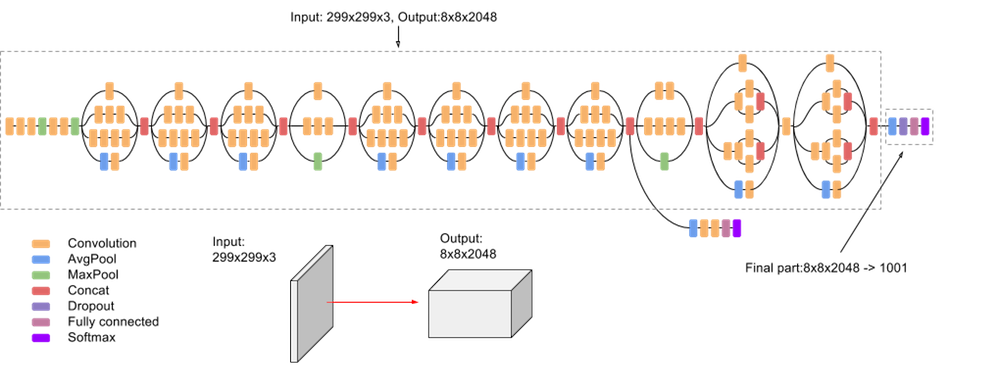

Red Neuronal Profunda ---> InceptionV3 + modelo de clasificación y modelo de regresión

In [ ]:
def model_inceptionv3(): 
    input_layer = Input(shape=(120,120,3)) # image dimensions
    
    # inceptionv3 = InceptionV3(include_top=False, weights='imagenet', classes=2)(input_layer)
    inceptionv3 = InceptionV3(include_top=False)(input_layer)  

    # Classification Model  
    f1 = GlobalMaxPooling2D()(inceptionv3)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1) # binary classification
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(inceptionv3)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1) # 4 coordinates
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [ ]:
facetracker_inceptionv3 = model_inceptionv3()
facetracker_inceptionv3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception_v3 (Functional)      (None, None, None,   21802784    ['input_3[0][0]']                
                                2048)                                                             
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 2048)        0           ['inception_v3[0][0]']           
 xPooling2D)                                                                                  

In [ ]:
X, y = train.as_numpy_iterator().next()

In [ ]:
X.shape

(8, 120, 120, 3)

In [ ]:
classes, coords = facetracker_inceptionv3.predict(X)

1/1 [==============================] - 9s 9s/step


In [ ]:
classes, coords

(array([[0.4125804 ],
        [0.5861647 ],
        [0.4423327 ],
        [0.8572253 ],
        [0.8075692 ],
        [0.7966241 ],
        [0.6967506 ],
        [0.41774046]], dtype=float32),
 array([[0.59439254, 0.44316378, 0.15936083, 0.17230266],
        [0.91044027, 0.55748194, 0.10826655, 0.30757987],
        [0.9063149 , 0.7395143 , 0.31510627, 0.50239545],
        [0.61400485, 0.58113676, 0.12277053, 0.619946  ],
        [0.87518173, 0.709286  , 0.18003981, 0.6230603 ],
        [0.4078651 , 0.72870576, 0.22741145, 0.42235327],
        [0.5980827 , 0.40047294, 0.5051748 , 0.5372161 ],
        [0.67310345, 0.4586099 , 0.23690936, 0.15512715]], dtype=float32))

### Optimizador y LR

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=(1./0.75 -1)/len(train))

### Funciones de pérdida (Loss)

In [ ]:
# Localization Loss and Classification Loss
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [ ]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [ ]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.52262235>

In [ ]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=10.774692>

## Entrenamiento NN

### Clase - Modelo NN 

In [ ]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [ ]:
model = FaceTracker(facetracker_inceptionv3)
model.compile(opt, classloss, regressloss)

### Performance

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40
450/450 [==============================] - 50s 54ms/step - total_loss: 0.8933 - class_loss: 0.2300 - regress_loss: 0.7783 - val_total_loss: 0.1629 - val_class_loss: 0.0012 - val_regress_loss: 0.1623
Epoch 2/40
450/450 [==============================] - 38s 51ms/step - total_loss: 0.2794 - class_loss: 0.0774 - regress_loss: 0.2407 - val_total_loss: 0.1988 - val_class_loss: 0.0237 - val_regress_loss: 0.1870
Epoch 3/40
450/450 [==============================] - 38s 55ms/step - total_loss: 0.1818 - class_loss: 0.0409 - regress_loss: 0.1613 - val_total_loss: 0.2336 - val_class_loss: 4.0556e-05 - val_regress_loss: 0.2336
Epoch 4/40
450/450 [==============================] - 38s 55ms/step - total_loss: 0.1256 - class_loss: 0.0288 - regress_loss: 0.1111 - val_total_loss: 0.0753 - val_class_loss: 2.4175e-04 - val_regress_loss: 0.0752
Epoch 5/40
450/450 [==============================] - 36s 52ms/step - total_loss: 0.1032 - class_loss: 0.0220 - regress_loss: 0.0922 - val_total_loss: 0

In [ ]:
hist.history

{'total_loss': [1.6636052131652832,
  1.9760792255401611,
  0.06539200246334076,
  0.11155198514461517,
  0.08423727005720139,
  0.058340247720479965,
  0.038277994841337204,
  0.016782160848379135,
  0.02371184155344963,
  0.04167574644088745,
  0.024250665679574013,
  0.01857115887105465,
  0.02522345259785652,
  0.019894082099199295,
  0.036582667380571365,
  0.01771008037030697,
  0.011213963851332664,
  0.012751996517181396,
  0.008292531594634056,
  0.016130732372403145,
  0.007807658985257149,
  0.011404995806515217,
  0.00774935120716691,
  0.013114494271576405,
  0.029569368809461594,
  0.015061995945870876,
  0.006667399313300848,
  0.016200847923755646,
  0.01132327038794756,
  0.004918874241411686,
  0.012350808829069138,
  0.006626790389418602,
  0.0029411599971354008,
  0.011372490786015987,
  0.010176164098083973,
  0.014556888490915298,
  0.007008611690253019,
  0.009897761978209019,
  0.0045134443789720535,
  0.010297978296875954],
 'class_loss': [0.45992136001586914,


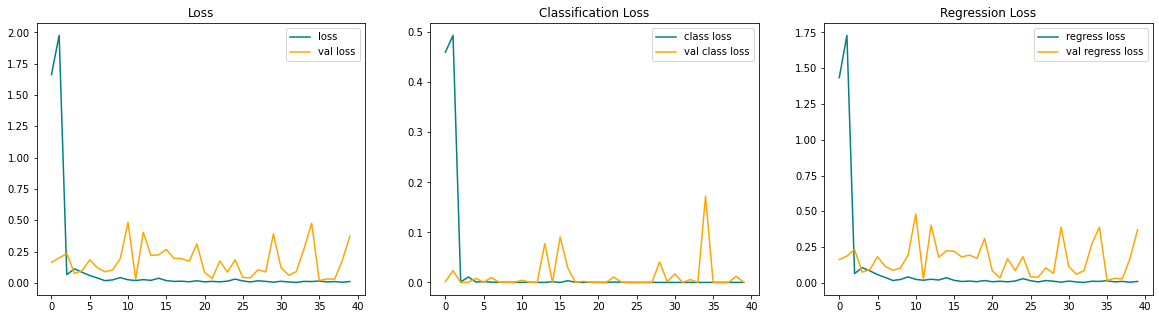

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

## Predicciones

### Test set

In [ ]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker_inceptionv3.predict(test_sample[0])

1/1 [==============================] - 0s 27ms/step


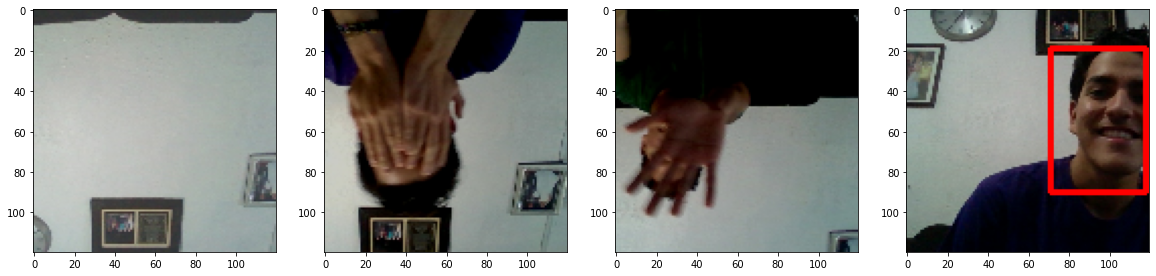

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

## Exportación del Modelo

In [ ]:
facetracker_inceptionv3.save('FaceDetectionModelInceptionV3.h5')

## Importación del Modelo

In [ ]:
facetracker = load_model('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/FaceDetectionModelInceptionV3.h5')